# Calibration with conformal inference

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
import pickle
import os
import admix_prs
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# target at [5%, 95%] interval
TARGET_QUANTILE = 0.05
TARGET_QUANTILE_Z = scipy.stats.norm.ppf(1 - TARGET_QUANTILE)

np.random.seed(1)

In [3]:
with open("df_res_list.pkl", "rb") as f:
    df_res_list = pickle.load(f)

In [4]:
df_raw = df_res_list[0].copy()
hsq = 0.25

# correct for the PRS-MEAN, such that it has the same mean as the PHENO
df_raw["PRS_MEAN"] -= df_raw["PRS_MEAN"].mean() - df_raw["PHENO"].mean()

df_raw["PHENO_STD"] = np.sqrt(df_raw["PRS_STD"] ** 2 + (1 - hsq))
df_raw["PHENO_LOWER"] = df_raw["PRS_MEAN"] - df_raw["PHENO_STD"] * TARGET_QUANTILE_Z
df_raw["PHENO_UPPER"] = df_raw["PRS_MEAN"] + df_raw["PHENO_STD"] * TARGET_QUANTILE_Z
df_raw["PRS_LOWER"] = df_raw["PRS_MEAN"] - df_raw["PRS_STD"] * TARGET_QUANTILE_Z
df_raw["PRS_UPPER"] = df_raw["PRS_MEAN"] + df_raw["PRS_STD"] * TARGET_QUANTILE_Z

# generate some random covariates
df_raw["AGE"] = np.random.randint(100, size=len(df_raw))
df_raw["SEX"] = np.random.randint(2, size=len(df_raw))

,r2,coverage,length
SEX,,,
0,0.186130,0.899711,3.003507
1,0.186605,0.899779,3.003947


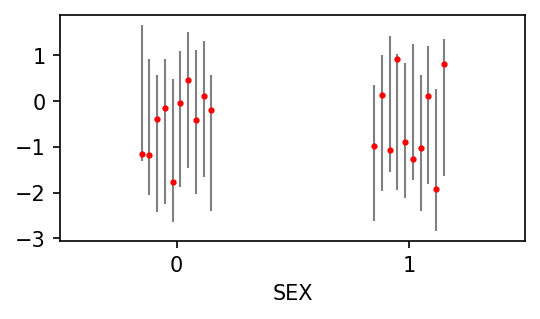

In [5]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=150)

admix_prs.plot_calibration(
    df=df_raw,
    y_col="PHENO",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="SEX",
    ax=ax,
)

display(
    admix_prs.evaluate(
        df_raw,
        true_col="PHENO",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="SEX",
    )
)

# Case 1: phenotype mean as a function of covariates

In [6]:
df1 = df_raw.copy()
df1["PHENO"] += (df1["SEX"] - 0.5) * 3

,r2,coverage,length
SEX,,,
0,0.186130,0.496890,3.003507
1,0.186605,0.496727,3.003947


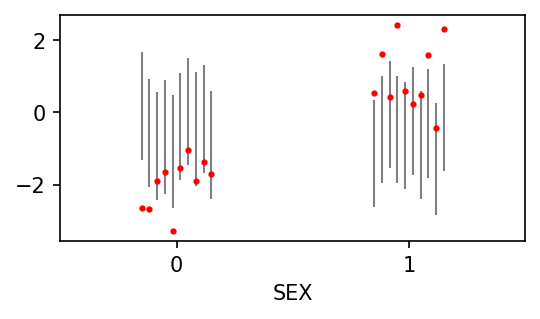

In [7]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=150)
admix_prs.plot_calibration(
    df=df1,
    y_col="PHENO",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="SEX",
    ax=ax,
)
display(
    admix_prs.evaluate(
        df1,
        true_col="PHENO",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="SEX",
    )
)

2022-01-25 15:59.36 [info     ] Regress pred_col=PRED against mean_adjust_cols=['SEX'] fitted with `calibrate_index` individuals
2022-01-25 15:59.36 [info     ] mean_model.summary():                             OLS Regression Results                            
Dep. Variable:                  PHENO   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     3694.
Date:                Tue, 25 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:59:36   Log-Likelihood:                -3215.9
No. Observations:                2429   AIC:                             6438.
Df Residuals:                    2426   BIC:                             6455.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    st

,r2,coverage,length
SEX,,,
0,0.186130,0.899346,3.003507
1,0.186605,0.900488,3.003947


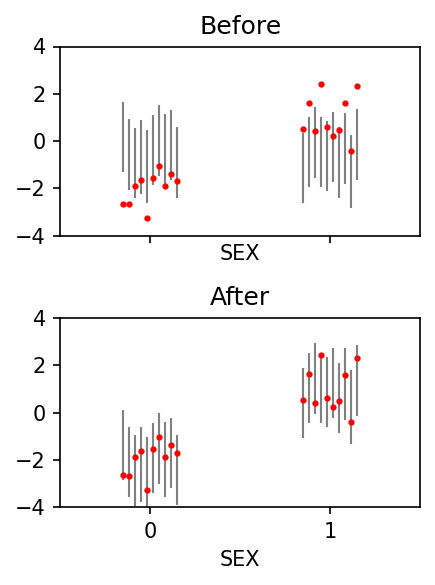

In [8]:
np.random.seed(1)
# use 5% of the individual for calibration
calibrate_idx = np.random.choice(df1.index, size=int(len(df1) * 0.05), replace=False)

# perform calibration
df1_calibrated = admix_prs.calibrate_pred(
    df1,
    true_col="PHENO",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    calibrate_idx=calibrate_idx,
    mean_adjust_cols=["SEX"],
)
df1_calibrated[["PHENO", "SEX"]] = df1[["PHENO", "SEX"]].reindex(df1_calibrated.index)

display(
    admix_prs.evaluate(
        df1_calibrated,
        true_col="PHENO",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="SEX",
    )
)

# visualize before and after

fig, axes = plt.subplots(figsize=(3, 4), dpi=150, nrows=2, sharex=True)
admix_prs.plot_calibration(
    df=df1,
    y_col="PHENO",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="SEX",
    ax=axes[0],
)

admix_prs.plot_calibration(
    df=df1_calibrated,
    y_col="PHENO",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="SEX",
    ax=axes[1],
)
axes[0].set_ylim(-4, 4)
axes[0].set_title("Before")
axes[1].set_ylim(-4, 4)
axes[1].set_title("After")
fig.tight_layout()

# Case 2: variance as a function of covariates

In [9]:
df2 = df_raw.copy()

df2["PHENO"] += np.random.normal(scale=np.sqrt(df2["AGE"]) * 0.4)
df2["AGE_Q"] = pd.qcut(df2["AGE"], q=5).cat.codes

np.random.seed(1)
# use 5% of the individual for calibration
calibrate_idx = np.random.choice(df2.index, size=int(len(df2) * 0.05), replace=False)

# perform calibration
df2_calibrated = admix_prs.calibrate_pred(
    df2,
    true_col="PHENO",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    calibrate_idx=calibrate_idx,
    mean_adjust_cols=["AGE"],
)
df2_calibrated[["PHENO", "AGE_Q"]] = df2[["PHENO", "AGE_Q"]].reindex(
    df2_calibrated.index
)

2022-01-25 15:59.36 [info     ] Regress pred_col=PRED against mean_adjust_cols=['AGE'] fitted with `calibrate_index` individuals
2022-01-25 15:59.36 [info     ] mean_model.summary():                             OLS Regression Results                            
Dep. Variable:                  PHENO   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     52.30
Date:                Tue, 25 Jan 2022   Prob (F-statistic):           5.76e-23
Time:                        15:59:36   Log-Likelihood:                -6070.7
No. Observations:                2429   AIC:                         1.215e+04
Df Residuals:                    2426   BIC:                         1.216e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    st

,r2,coverage,length
AGE_Q,,,
0,0.074047,0.685443,3.004056
1,0.031768,0.465400,3.003792
2,0.020615,0.384368,3.003091
3,0.016169,0.332992,3.003541
4,0.018161,0.298350,3.004139


,r2,coverage,length
AGE_Q,,,
0,0.074121,0.680055,3.004056
1,0.031776,0.468085,3.003792
2,0.020635,0.386545,3.003091
3,0.016151,0.331356,3.003541
4,0.018137,0.298026,3.004139


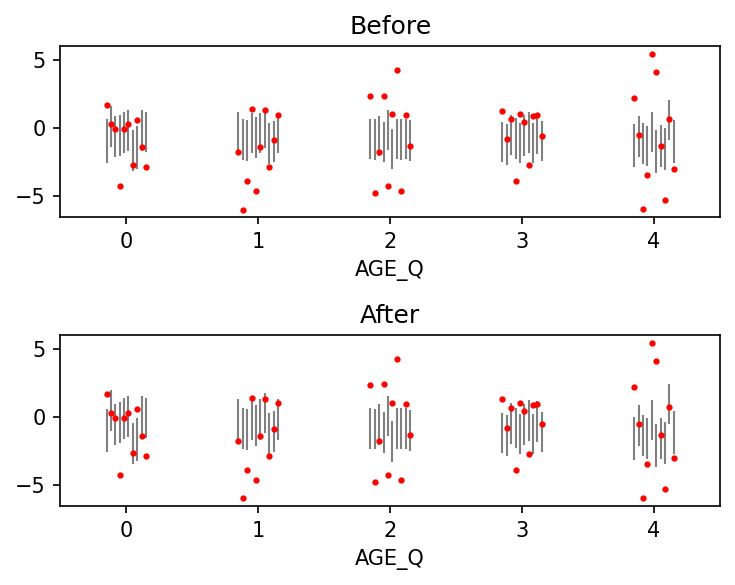

In [10]:
fig, axes = plt.subplots(figsize=(5, 4), dpi=150, nrows=2, sharey=True)
admix_prs.plot_calibration(
    df=df2,
    y_col="PHENO",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="AGE_Q",
    n=10,
    ax=axes[0],
)
axes[0].set_title("Before")
display(
    admix_prs.evaluate(
        df=df2,
        true_col="PHENO",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="AGE_Q",
    )
)
admix_prs.plot_calibration(
    df=df2_calibrated,
    y_col="PHENO",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="AGE_Q",
    n=10,
    ax=axes[1],
)
axes[1].set_title("After")

display(
    admix_prs.evaluate(
        df=df2_calibrated,
        true_col="PHENO",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="AGE_Q",
    )
)
fig.tight_layout()

In [11]:
# perform calibration with TARGET_QUANTILE adjusted
df2_calibrated = admix_prs.calibrate_pred(
    df2,
    true_col="PHENO",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    calibrate_idx=calibrate_idx,
    method="scale",
    quantile_adjust_cols=["AGE"],
    q=TARGET_QUANTILE,
)
df2_calibrated[["PHENO", "AGE_Q"]] = df2[["PHENO", "AGE_Q"]].reindex(
    df2_calibrated.index
)

2022-01-25 15:59.37 [info     ] Regress pred_col=PRED against mean_adjust_cols=[] fitted with `calibrate_index` individuals
2022-01-25 15:59.37 [info     ] mean_model.summary():                             OLS Regression Results                            
Dep. Variable:                  PHENO   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     104.1
Date:                Tue, 25 Jan 2022   Prob (F-statistic):           5.95e-24
Time:                        15:59:37   Log-Likelihood:                -6071.0
No. Observations:                2429   AIC:                         1.215e+04
Df Residuals:                    2427   BIC:                         1.216e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err

,r2,coverage,length
AGE_Q,,,
0,0.074047,0.685443,3.004056
1,0.031768,0.465400,3.003792
2,0.020615,0.384368,3.003091
3,0.016169,0.332992,3.003541
4,0.018161,0.298350,3.004139


,r2,coverage,length
AGE_Q,,,
0,0.074047,0.914381,5.238668
1,0.031768,0.881843,7.444999
2,0.020615,0.891676,9.613798
3,0.016169,0.910207,11.766898
4,0.018161,0.924711,13.859871


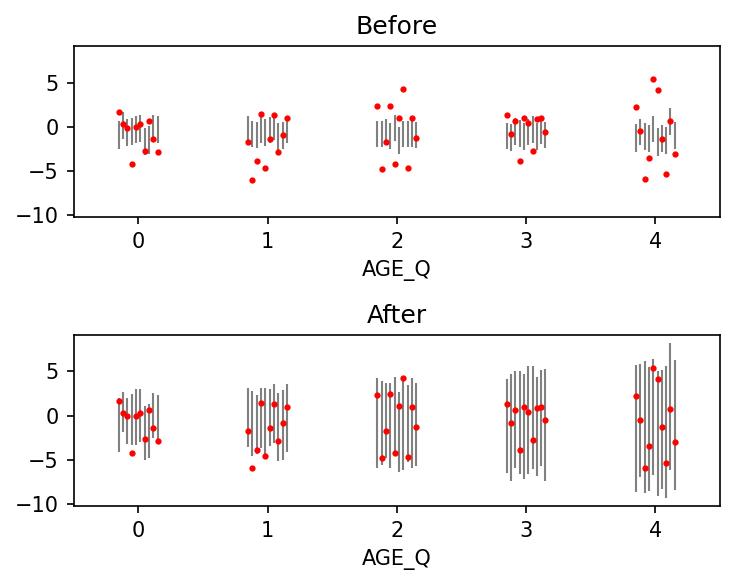

In [12]:
fig, axes = plt.subplots(figsize=(5, 4), dpi=150, nrows=2, sharey=True)
admix_prs.plot_calibration(
    df=df2,
    y_col="PHENO",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="AGE_Q",
    n=10,
    ax=axes[0],
)
axes[0].set_title("Before")
display(
    admix_prs.evaluate(
        df=df2,
        true_col="PHENO",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="AGE_Q",
    )
)

admix_prs.plot_calibration(
    df=df2_calibrated,
    y_col="PHENO",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="AGE_Q",
    n=10,
    ax=axes[1],
)
axes[1].set_title("After")

display(
    admix_prs.evaluate(
        df=df2_calibrated,
        true_col="PHENO",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="AGE_Q",
    )
)
fig.tight_layout()